The goal of this exercise is to suggest to Instacart customers items that they might want to purchase based on past orders. The point is not to create an award-winning algorithm, but to place yourself in the shoes of a data science consultant. 

1. Data Exploration    
    1. What initial insights can you get from a first exploration of the dataset?  
    2. Do some variables seem to have more importance than other? What transformations might be needed?  
2. Prediction    
    1. Describe your overall approach: how did you formulate the problem to make recommendations?  
    2. What model did you choose? Why?  
    3. How did you assess performance of your model? Which metrics seemed particularly important to you?  
    4. Please present your results and model performance  
    5. How would you suggest delivering the recommendations to your client?  
3. Insights and Next Steps    
    1. What insights can you extract from your analysis?  
    2. What are some of the things you would suggest as next steps for your client?  

# Loading libraries

In [1]:
#data processing libraries
import pandas as pd
import numpy as np

#Visualization libraries
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff

#warning and other libraries
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.float_format', lambda x: '%.2f' % x) 

# Initial thoughts

1. Important to note that I have a RAM limitation of 8Gb and time constraints of 15 hours for this problem. Due to this, I am ruling out building ML models which tends to take longer time to train - Neural Nets, Adaboost etc.
2. I also want venture into spark MLib library for recommendation system algorithms such as ALS for collaborative filtering etc. This would greatly speed up building the recommendation model.

In [2]:
#Loading all the data-sets
aisles = pd.read_csv('aisles.csv')
departments = pd.read_csv('departments.csv')
order_products_prior = pd.read_csv('order_products__prior.csv')
order_products_train = pd.read_csv('order_products__train_cap.csv')
orders = pd.read_csv('orders.csv')
products = pd.read_csv('products.csv')

# Exploratory Data Analysis

The dataset is an anonymized sample of over 3,000,000 unique grocery orders from more than 200,000 Instacart users. 

In [3]:
#Combining order_products_prior and order_products_train
order_products = pd.concat([order_products_prior, order_products_train])
order_products.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [4]:
# I want to see the number of unique orders and unique products
orders_unique = len(set(order_products.order_id))
products_unique = len(set(order_products.product_id))
print("There are %s orders for %s products" %(orders_unique, products_unique))

There are 3313280 orders for 49681 products


In [5]:
# Now let's have a look at the number of total aisles, departments and products
print('Total aisles: {} '.format(aisles.shape[0]) + 'Total departments: {} '.format(departments.shape[0]) + 'Total products: {} '.format(products.shape[0]))

Total aisles: 134 Total departments: 21 Total products: 49688 


In [6]:
#206209 missing values exist in the data-set and primarily due to the feature days_since_prior_order.
#Already explored other files and not didnot find any missing columns in them.
orders.isnull().sum()

order_id                       0
user_id                        0
eval_set                       0
order_number                   0
order_dow                      0
order_hour_of_day              0
days_since_prior_order    206209
dtype: int64

In [7]:
print('Missing values (percentage): {} '.format(206209*100/3421083))

Missing values (percentage): 6.027594185817766 


In [8]:
# reusable function for ploting bar_charts
def bar_chart(combined, title, x_axis, y_axis, cmax):
    data = [
     go.Bar(
            x=combined.index, # assign x as the dataframe column 'x'
            y=combined.values,
            marker=dict(
                cmax=cmax,
                cmin=0,
                color=list(range(0,cmax)),
                colorbar=dict(
                    title='legend'
                ),
                colorscale='Viridis'
            ) ,
        )
    ]

    layout = go.Layout(dict(title = title,
                            plot_bgcolor  = "rgb(243,243,243)",
                            paper_bgcolor = "rgb(243,243,243)",
                            yaxis=dict(
                                title=y_axis),
                            xaxis=dict(
                                title=x_axis)
                           )
                      )

    fig = go.Figure(data=data, layout=layout)
    py.iplot(fig)

## How many products are added to cart in an order?

In [9]:
# distribution of number of products added to cart
combined = order_products.groupby("order_id")["add_to_cart_order"].aggregate("max").reset_index()
combined = combined.add_to_cart_order.value_counts()

bar_chart(combined, "Frequent number of products added in the cart", "Number of products in cart", "Number of orders", 50)

Inference - we observe a right skewed distribution for number of orders vs number of products. Most orders have 4-8 different products.

# Which are the top 10 most ordered products?

In [10]:
# top 10 most ordered products
combined = order_products.groupby("product_id")["reordered"].aggregate({'Total_reorders': 'count'}).reset_index()
combined = pd.merge(combined, products[['product_id', 'product_name']], how='left', on=['product_id'])
combined = combined.sort_values(by='Total_reorders', ascending=False)[:10]
combined  = combined.groupby(['product_name']).sum()['Total_reorders'].sort_values(ascending=False)

bar_chart(combined, 'Most ordered products', '', 'Number of orders', 10)

Inference - Bananas, strawberies, spinach, avacado, lemo and whole milk make up the top 10 most ordered products.

# What percentage of the ordered products are reordered?

In [11]:
combined = order_products.groupby("reordered")["product_id"].aggregate({'Total_products': 'count'}).reset_index()
combined['Ratios'] = combined["Total_products"].apply(lambda x: x /combined['Total_products'].sum())
combined  = combined.groupby(['reordered']).sum()['Total_products'].sort_values(ascending=False)

#Let's plot that on a pie chart
trace = go.Pie(labels = combined.index ,
               values = combined.values ,
               marker = dict(colors =  [ 'rgb(0,155,255)' ,'rgb(235,30,0)'],
                             line = dict(color = "white",
                                         width =  1.3)
                            ),
               rotation = 90,
               hoverinfo = "label+value+text",
               hole = .5,
              )
layout = go.Layout(dict(title = "Customer re-order",
                        plot_bgcolor  = "rgb(243,243,243)",
                        paper_bgcolor = "rgb(243,243,243)",
                       )
                  )

data = [trace]
fig = go.Figure(data = data,layout = layout)
py.iplot(fig)

# Which are the most re-ordered products?

In [12]:
combined = order_products.groupby("product_id")["reordered"].aggregate({'reorder_sum': sum,'reorder_total': 'count'}).reset_index()
combined['reorder_prob'] = combined['reorder_sum'] / combined['reorder_total']
combined = pd.merge(combined, products[['product_id', 'product_name']], how='left', on=['product_id'])
combined = combined[combined.reorder_total > 100].sort_values(['reorder_prob'], ascending=False)[:20]
combined  = combined.groupby(['product_name']).sum()['reorder_prob'].sort_values(ascending=False)

bar_chart(combined, "Most re-ordered products", '', 'reorder probability', 20)

# What time of day do people order the most?

In [13]:
combined = orders.groupby("order_id")["order_hour_of_day"].aggregate("sum").reset_index()
combined = combined.order_hour_of_day.value_counts()

bar_chart(combined, 'Orders by hour of day', 'hour of the day', 'number of orders', 24)

# What day of week do people order the most?

In [14]:
combined = orders.groupby("order_id")["order_dow"].aggregate("sum").reset_index()
combined = combined.order_dow.value_counts()

bar_chart(combined, 'Orders by day of week', 'day of the week', 'number of orders', 7)

# How many days after do people order again?

In [15]:
combined = orders.groupby("order_id")["days_since_prior_order"].aggregate("sum").reset_index()
combined = combined.days_since_prior_order.value_counts()

bar_chart(combined, 'Number of orders vs period of re-order', 'days after initial order','number of orders', 31)

Inference - As you can observe 0 denotes first time orders, 7 and 30 also spikes up showing people tends re-order after a period of 7 days or 30 days.

In [16]:
print("Number of unique customers in the whole dataset : ",len(set(orders.user_id)))

Number of unique customers in the whole dataset :  206209


# Number of customers vs number of orders

In [17]:
combined = orders.groupby('user_id')['order_id'].apply(lambda x: len(x.unique())).reset_index()
combined = combined.groupby('order_id').aggregate("count")

data = [
     go.Bar(
            x=combined.index, # assign x as the dataframe column 'x'
            y=combined.user_id,
            marker=dict(
                cmax=101,
                cmin=0,
                color=list(range(0,101)),
                colorbar=dict(
                    title='legend'
                ),
                colorscale='Viridis'
            ) ,
        )
    ]

layout = go.Layout(dict(title = 'Numbers of Customers vs Number of Orders per customer',
                            plot_bgcolor  = "rgb(243,243,243)",
                            paper_bgcolor = "rgb(243,243,243)",
                           ),
                   yaxis=dict(
                                title='number of customers'),
                            xaxis=dict(
                                title='number of orders')
                      )

fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

Inference - majority of the customers have done 4 orders.

In [18]:
#Merging products, departments and aisles indexing files
products_departments_aisles = pd.merge(left =pd.merge(left=products, right=departments, how='left'), right=aisles, how='left')

## How many different products are there in each department?

In [19]:
combined = products_departments_aisles.groupby("department")["product_id"].aggregate({'Total_products': 'count'}).reset_index()
combined['Ratio'] = combined["Total_products"].apply(lambda x: x /combined['Total_products'].sum())
combined.sort_values(by='Total_products', ascending=False, inplace=True)
combined  = combined.groupby(['department']).sum()['Total_products'].sort_values(ascending=False)

bar_chart(combined, 'Number of products vs Department', '', 'number of products', 21)

## Total number of products by department and aisle

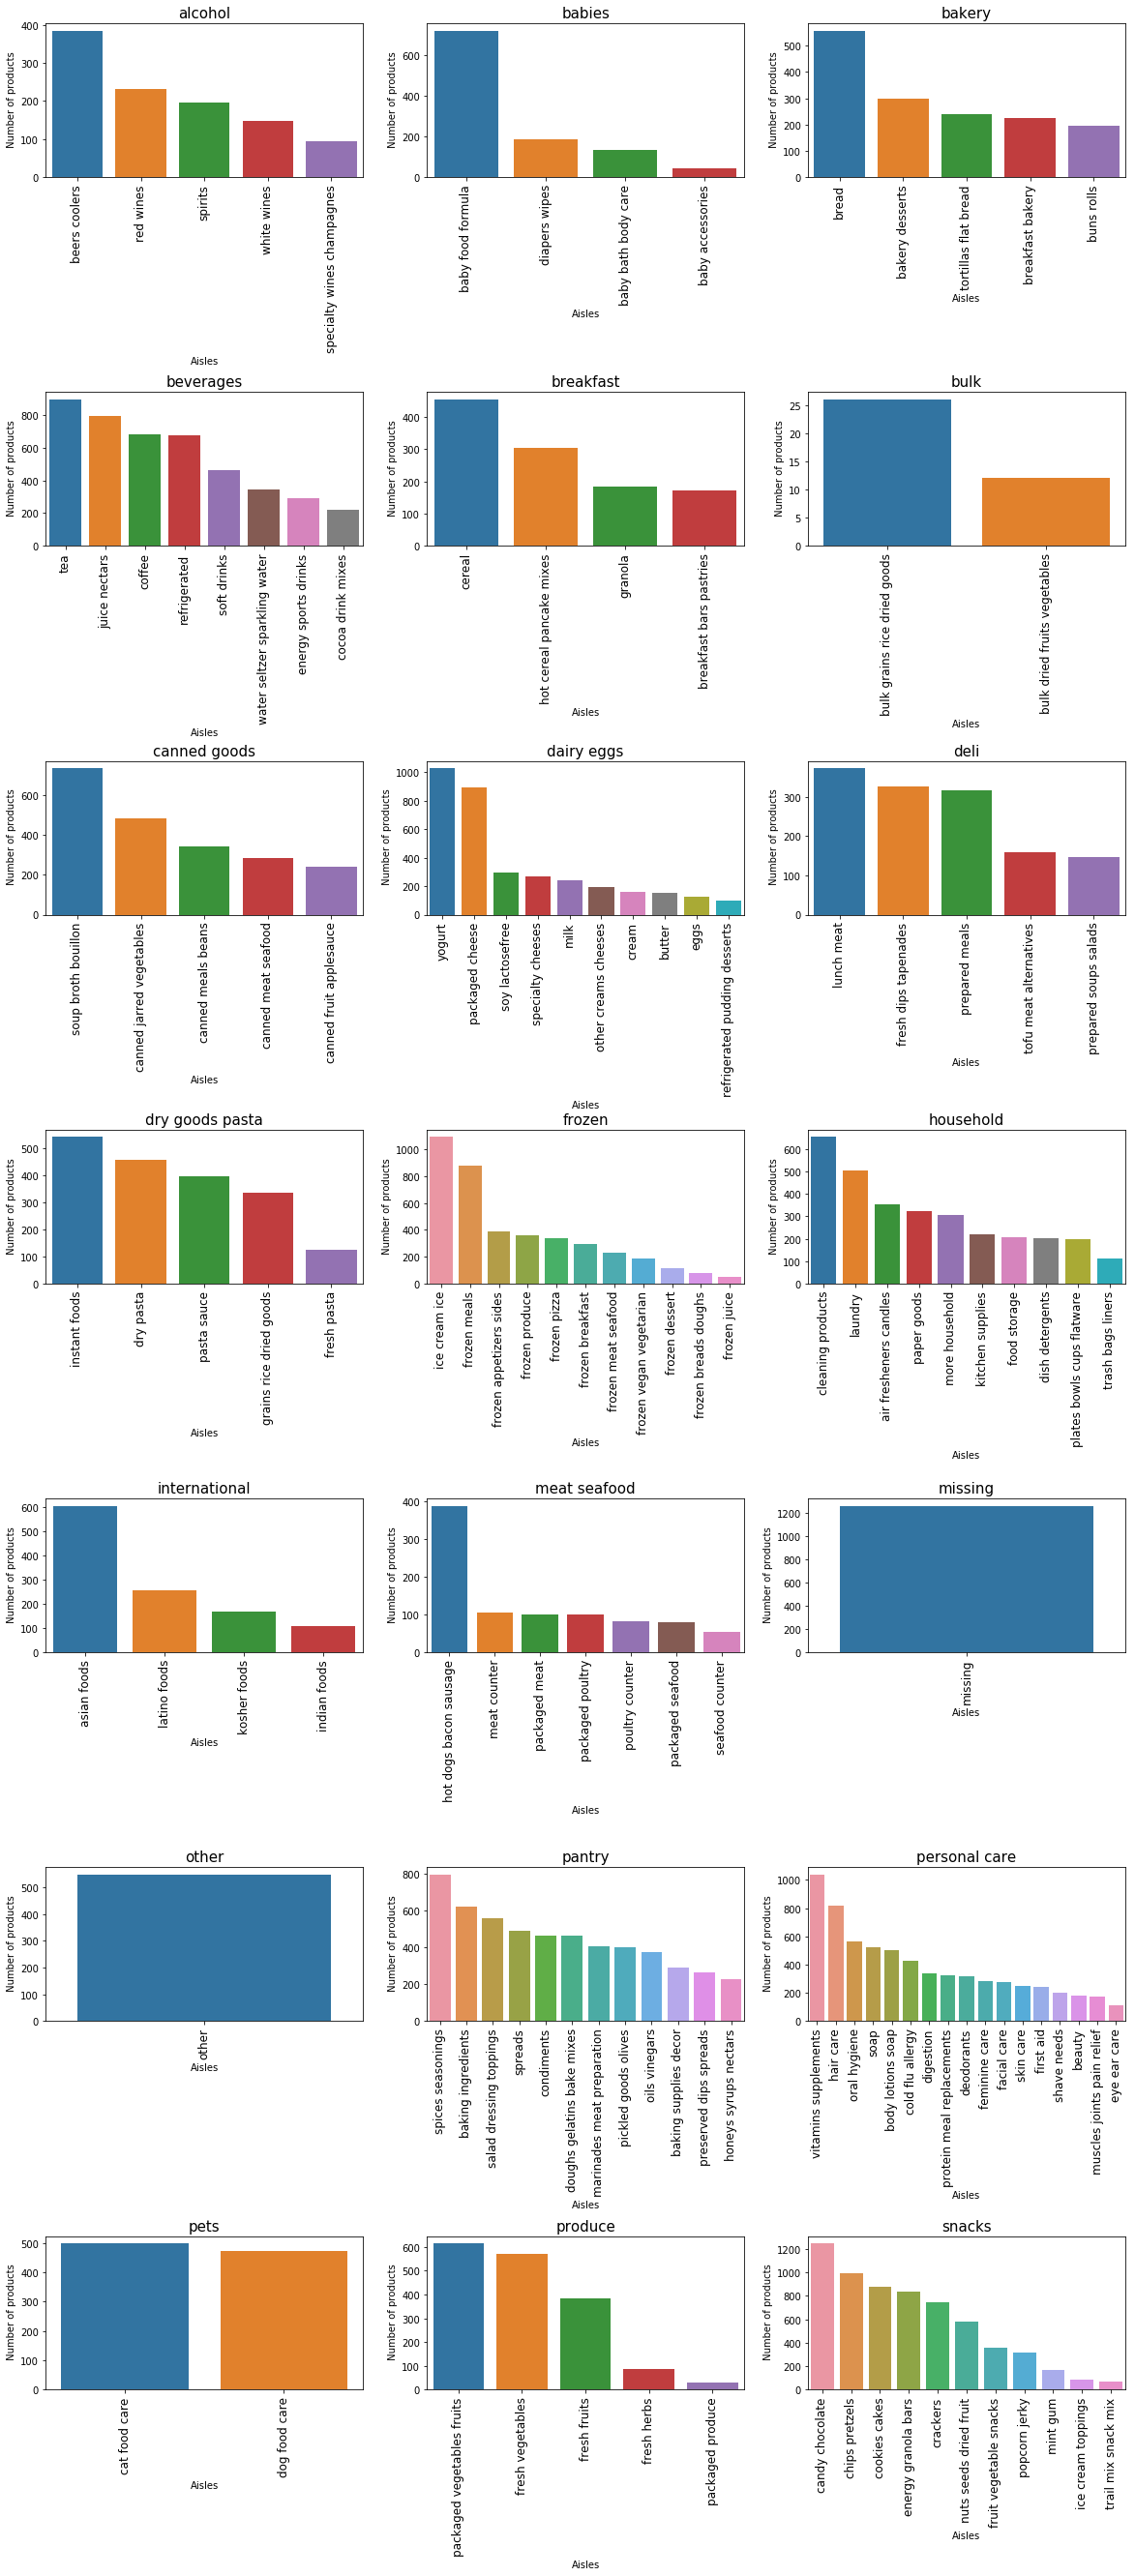

In [20]:
combined = products_departments_aisles.groupby(["department", "aisle"])["product_id"].aggregate({'Total_products': 'count'}).reset_index()
combined.sort_values(by='Total_products', ascending=False, inplace=True)

#Reusable seaborn plot
fig, axes = plt.subplots(7,3, figsize=(20,45), gridspec_kw =  dict(hspace=1.4))
for (aisle, group), ax in zip(combined.groupby(["department"]), axes.flatten()):
    g = sns.barplot(group.aisle, combined.Total_products , ax=ax)
    ax.set(xlabel = "Aisles", ylabel=" Number of products")
    g.set_xticklabels(labels = group.aisle,rotation=90, fontsize=12)
    ax.set_title(aisle, fontsize=15)

## Total number of products on unique aisles

In [21]:
combined = products_departments_aisles.groupby("aisle")["product_id"].aggregate({'Total_products': 'count'}).reset_index()
combined['Ratio'] = combined["Total_products"].apply(lambda x: x /combined['Total_products'].sum())
combined = combined.sort_values(by='Total_products', ascending=False)[:20]
combined  = combined.groupby(['aisle']).sum()['Total_products'].sort_values(ascending=False)

bar_chart(combined, 'Number of products vs Aisles', '', 'number of products', 20)

In [22]:
orders_product_train = orders[['user_id', 'order_id']].merge(order_products_train[['order_id', 'product_id']],
                                          how='inner', left_on='order_id', right_on='order_id')

orders_product_train = orders_product_train.merge(products_departments_aisles, how='inner', left_on='product_id',
                                         right_on='product_id')

## Number of orders vs department

In [23]:
combined = orders_product_train.groupby("department")["order_id"].aggregate({'Total_orders': 'count'}).reset_index()
combined['Ratio'] = combined["Total_orders"].apply(lambda x: x /combined['Total_orders'].sum())
combined.sort_values(by='Total_orders', ascending=False, inplace=True)
combined  = combined.groupby(['department']).sum()['Total_orders'].sort_values(ascending=False)

bar_chart(combined, 'Number of orders vs department', '', 'number of orders', 21)

## Number of orders by department and Aisle

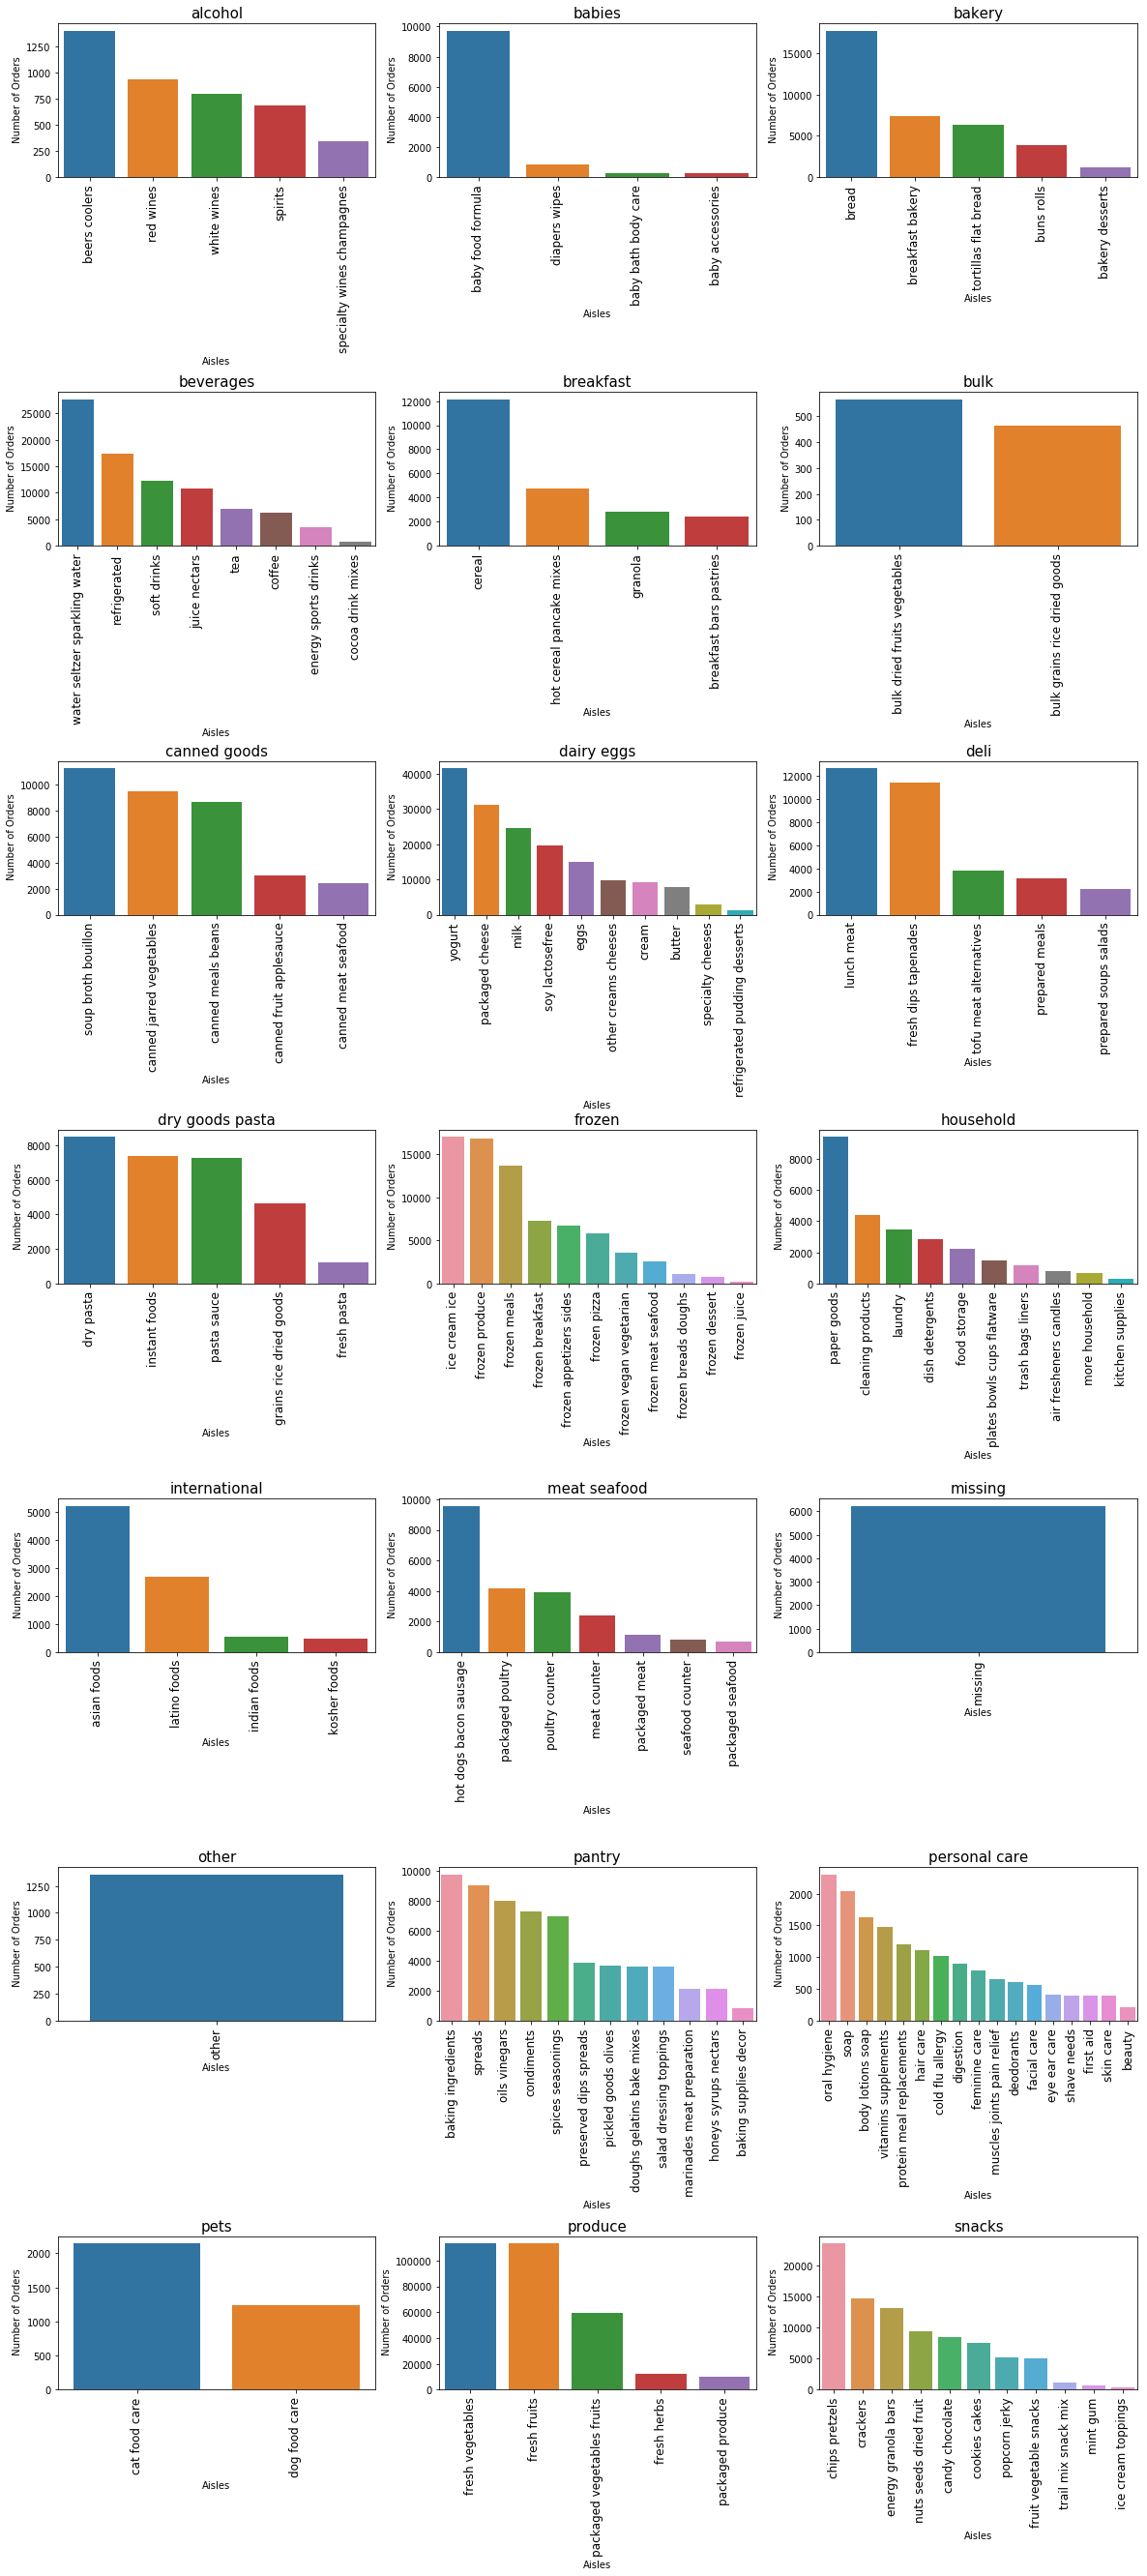

In [24]:
combined = orders_product_train.groupby(["department", "aisle"])["order_id"].aggregate({'Total_orders': 'count'}).reset_index()
combined.sort_values(by='Total_orders', ascending=False, inplace=True)

#Reusable seaborn plot
fig, axes = plt.subplots(7,3, figsize=(20,45), gridspec_kw =  dict(hspace=1.4))
for (aisle, group), ax in zip(combined.groupby(["department"]), axes.flatten()):
    g = sns.barplot(group.aisle, group.Total_orders , ax=ax)
    ax.set(xlabel = "Aisles", ylabel=" Number of Orders")
    g.set_xticklabels(labels = group.aisle,rotation=90, fontsize=12)
    ax.set_title(aisle, fontsize=15)